# 📦 Yes/No 음성 명령어 분류 모델 (MicroTFLite 대응)

TensorFlow 기반으로 간단한 음성 인식 모델을 학습하고, MicroTFLite 용으로 INT8 양자화 변환합니다.

- 대상 명령어: `yes`, `no`
- 데이터셋: `mini_speech_commands`
- 스펙트로그램 전처리: micro 형식
- 출력: 양자화된 `.tflite` 모델

In [15]:
# 1. 설정 및 버전 확인
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import layers, models

print(f"TensorFlow version: {tf.__version__}")
if tf.__version__ < "2.5.0":
    print("⚠️ TensorFlow 2.5.0 이상 권장.")

tf.random.set_seed(42)
np.random.seed(42)

TensorFlow version: 2.5.0


In [16]:
# 2. 데이터 다운로드 및 필터링
data_dir = pathlib.Path("data/mini_speech_commands")
if not data_dir.exists():
    tf.keras.utils.get_file(
        "mini_speech_commands.zip",
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir=".", cache_subdir="data")

TARGET_COMMANDS = ["yes", "no"]
all_files = tf.io.gfile.glob(str(data_dir) + "/*/*")
filtered_files = [f for f in all_files if pathlib.Path(f).parent.name in TARGET_COMMANDS]

files = tf.random.shuffle(tf.constant(filtered_files))
commands = np.array(TARGET_COMMANDS)
num_labels = len(commands)
print(f"총 파일 수: {len(files)}")

총 파일 수: 2000


In [17]:
# 3. 데이터 분할
train_size = int(0.8 * len(files))
val_size = int(0.1 * len(files))
test_size = len(files) - train_size - val_size

train_files = files[:train_size]
val_files = files[train_size:train_size+val_size]
test_files = files[train_size+val_size:]

print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

Train: 1600, Val: 200, Test: 200


In [18]:
# 4. 오디오 처리 함수 정의
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [19]:
# 5. Micro-style 스펙트로그램 생성
RESIZE_HEIGHT, RESIZE_WIDTH = 8, 8
TARGET_AUDIO_LEN = 16000

def get_spectrogram(waveform):
    zero_padding = tf.zeros([TARGET_AUDIO_LEN] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)
    waveform = waveform[:TARGET_AUDIO_LEN]
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

def get_spectrogram_resized_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    spectrogram = tf.image.resize(spectrogram, [RESIZE_HEIGHT, RESIZE_WIDTH])
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

In [26]:
# 6. 데이터셋 구성
AUTOTUNE = tf.data.AUTOTUNE
'''
def preprocess_dataset(file_paths):
    ds = tf.data.Dataset.from_tensor_slices(file_paths)
    ds = ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    ds = ds.map(get_spectrogram_resized_and_label_id, num_parallel_calls=AUTOTUNE)
    return ds
'''
def preprocess_dataset(file_paths):
    ds = tf.data.Dataset.from_tensor_slices(file_paths)
    ds = ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    ds = ds.map(get_spectrogram_resized_and_label_id, num_parallel_calls=AUTOTUNE)
    # 여기서 평탄화
    ds = ds.map(lambda x, y: (tf.reshape(x, [64]), y),num_parallel_calls=AUTOTUNE)
    return ds

batch_size = 64
train_ds = preprocess_dataset(train_files).batch(batch_size).cache().prefetch(AUTOTUNE)
val_ds = preprocess_dataset(val_files).batch(batch_size).cache().prefetch(AUTOTUNE)
test_ds = preprocess_dataset(test_files)#.batch(batch_size).cache().prefetch(AUTOTUNE)

In [39]:
# 1) Flat input 64 길이 받도록
model = models.Sequential([
    # (batch,64) 짜리 2D 텐서를 첫 입력으로 받음
    layers.InputLayer(input_shape=(64,), name="flat_input"),  

    # 2) 다시 (8,8,1) 4D 텐서로 리셰이프
    layers.Reshape(target_shape=(8, 8, 1), name="reshape_to_8x8x1"),

    # 3) 원래 Conv2D 계층들
    layers.Conv2D(8, (3,3), activation="relu"),
    layers.Conv2D(4, (3,3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.GlobalAveragePooling2D(),

    # 4) Dense 분류기
    layers.Dense(2, activation="relu"),
    layers.Dense(2, activation="softmax"),
], name="gesture_flat_model")
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()
''' 1.->8,4,0.4,2,2
    2.->
'''

Model: "gesture_flat_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_to_8x8x1 (Reshape)   (None, 8, 8, 1)           0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 8)           80        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 4)           292       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 4)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2, 2, 4)           0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 4)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)          

' 1.->8,4,0.4,2,2\n    2.->\n'

In [46]:
# 8. 모델 훈련
EPOCHS = 500
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, 
                    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),)

Epoch 1/500
25/25 [==============================] - 0s 3ms/step - loss: 0.3638 - accuracy: 0.8706 - val_loss: 0.3409 - val_accuracy: 0.8750
Epoch 2/500
25/25 [==============================] - 0s 2ms/step - loss: 0.3548 - accuracy: 0.8781 - val_loss: 0.3340 - val_accuracy: 0.8900
Epoch 3/500
25/25 [==============================] - 0s 2ms/step - loss: 0.3463 - accuracy: 0.8744 - val_loss: 0.3339 - val_accuracy: 0.8900
Epoch 4/500
25/25 [==============================] - 0s 2ms/step - loss: 0.3520 - accuracy: 0.8731 - val_loss: 0.3305 - val_accuracy: 0.8950
Epoch 5/500
25/25 [==============================] - 0s 2ms/step - loss: 0.3543 - accuracy: 0.8731 - val_loss: 0.3310 - val_accuracy: 0.8900
Epoch 6/500
25/25 [==============================] - 0s 2ms/step - loss: 0.3367 - accuracy: 0.8788 - val_loss: 0.3218 - val_accuracy: 0.9000
Epoch 7/500
25/25 [==============================] - 0s 2ms/step - loss: 0.3279 - accuracy: 0.8894 - val_loss: 0.3163 - val_accuracy: 0.9000
Epoch 8/500
2

Test set accuracy: 84%


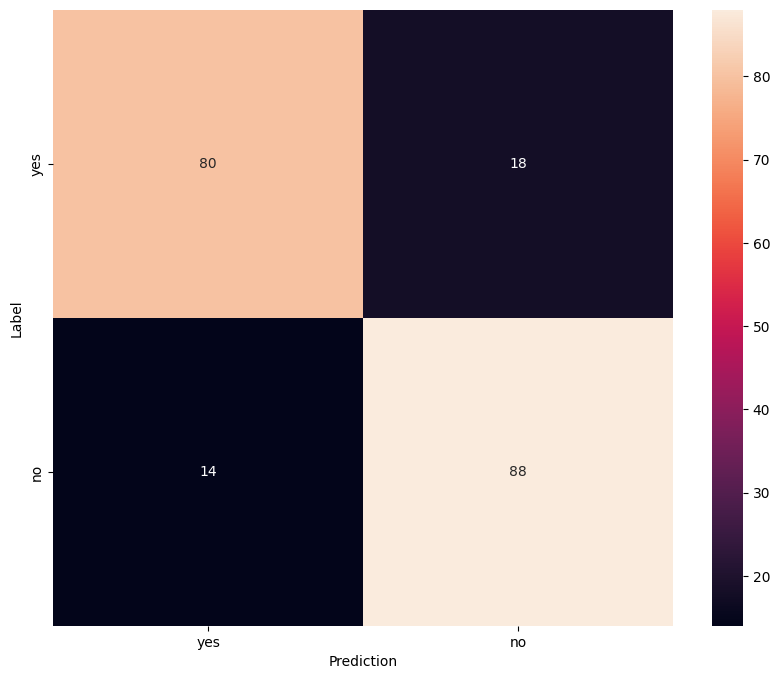

In [41]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

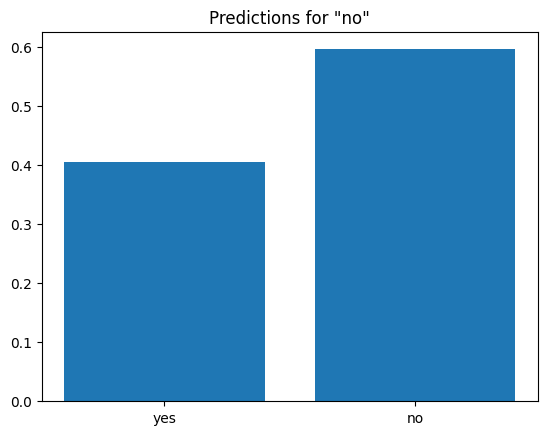

In [42]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

In [43]:
# 9. 양자화용 대표 데이터셋
def representative_data_gen():
    for input_value, _ in train_ds.take(100):
        yield [tf.cast(input_value, tf.float32)]

In [44]:
# 10. TFLite 변환
converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_t = converter.convert()
with open("audio_yesno_micro.tflite", "wb") as f:
    f.write(model_t)
print("✅ TFLite 모델 저장 완료: audio_yesno_micro.tflite")


converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_model = converter.convert()

with open("audio_yesno_micro_q.tflite", "wb") as f:
    f.write(tflite_model)
print("✅ TFLite 모델 저장 완료: audio_yesno_micro_q.tflite")

INFO:tensorflow:Assets written to: C:\Users\phant\AppData\Local\Temp\tmpvivdq5pa\assets


INFO:tensorflow:Assets written to: C:\Users\phant\AppData\Local\Temp\tmpvivdq5pa\assets


✅ TFLite 모델 저장 완료: audio_yesno_micro.tflite
INFO:tensorflow:Assets written to: C:\Users\phant\AppData\Local\Temp\tmpp1o0w_qw\assets


INFO:tensorflow:Assets written to: C:\Users\phant\AppData\Local\Temp\tmpp1o0w_qw\assets


✅ TFLite 모델 저장 완료: audio_yesno_micro_q.tflite


In [45]:
!xxd -i audio_yesno_micro_q.tflite > audio_yesno_micro_q.cpp
!type audio_yesno_micro_q.cpp

unsigned char audio_yesno_micro_q_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x4c, 0x00, 0x00, 0x00, 0x70, 0x03, 0x00, 0x00,
  0x80, 0x03, 0x00, 0x00, 0xa4, 0x15, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00, 0x08, 0x00, 0x00, 0x00,
  0x1a, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x13, 0x00, 0x00, 0x00,
  0x6d, 0x69, 0x6e, 0x5f, 0x72, 0x75, 0x6e, 0x74, 0x69, 0x6d, 0x65, 0x5f,
  0x76, 0x65, 0x72, 0x73, 0x69, 0x6f, 0x6e, 0x00, 0x1b, 0x00, 0x00, 0x00,
  0x20, 0x03, 0x00, 0x00, 0x18, 0x03, 0x00, 0x00, 0x04, 0x03, 0x00, 0x00,
  0xf0, 0x02, 0x00, 0x00, 0xdc, 0x02, 0x00, 0x00, 0xc8, 0x02, 0x00, 0x00,
  0xb0, 0x02, 0x00, 0x00, 0x58, 0x02, 0x00, 0x00, 0x28, 0x02, 0x0